Loading dataset...
Loaded 1596 samples with 96 features each.
Applying PCA...
k=1 -> Accuracy: 93.44%
k=3 -> Accuracy: 76.25%
k=5 -> Accuracy: 46.56%
k=7 -> Accuracy: 48.75%

Best k = 1, Accuracy = 93.44%


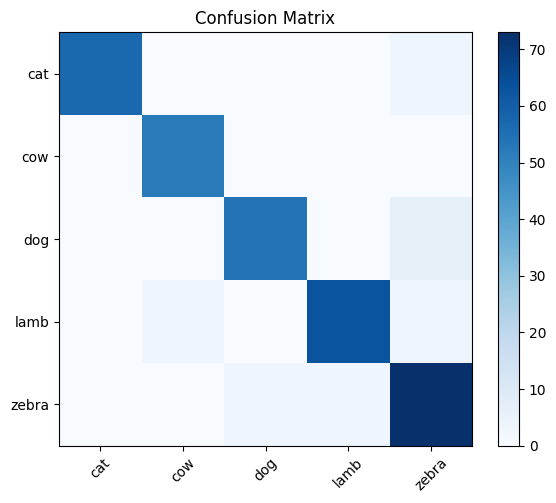

Class        Precision  Recall  F1-Score  Support
----------------------------------------------
cat             100.00   95.00     97.44       60
cow              94.55  100.00     97.20       52
dog              94.74   90.00     92.31       60
lamb             95.45   91.30     93.33       69
zebra            85.88   92.41     89.02       79
----------------------------------------------
Avg/Total        94.12   93.74     93.86      320


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============== CONFIG ===============
DATASET_DIR = "/kaggle/input/animal-images/dataset"
CATEGORIES = ["cat", "cow", "dog", "lamb", "zebra"]
IMG_SIZE = (64, 64)        # Resize images to 64x64
BINS = 32                  # Histogram bins per channel
K_VALUES = [1, 3, 5, 7]    # k values to test in KNN
PCA_COMPONENTS = 50        # Number of PCA components
AUGMENT = True             # Enable augmentation
# =====================================

def load_and_resize_image(path, size=IMG_SIZE):
    img = plt.imread(path)
    # Convert float images (0-1) to 0-255 uint8
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    old_h, old_w = img.shape[:2]
    new_h, new_w = size
    row_idx = (np.linspace(0, old_h - 1, new_h)).astype(int)
    col_idx = (np.linspace(0, old_w - 1, new_w)).astype(int)
    resized = img[row_idx[:, None], col_idx]
    return resized

def horizontal_flip(img):
    return np.fliplr(img)

def rotate_90(img, k=1):
    return np.rot90(img, k)

def extract_features(img):
    """Extract 32-bin color histogram per channel and concatenate."""
    features = []
    for ch in range(3):  # RGB channels
        hist, _ = np.histogram(img[:, :, ch], bins=BINS, range=(0, 256))
        features.extend(hist)
    return np.array(features)

def normalize_features(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)

def apply_pca(X, n_components):
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    cov = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    sorted_idx = np.argsort(eigvals)[::-1]
    top_vecs = eigvecs[:, sorted_idx[:n_components]]
    X_reduced = np.dot(X_centered, top_vecs)
    return X_reduced, mean, top_vecs

def knn_predict(X_train, y_train, X_test, k):
    preds = []
    for test_pt in X_test:
        dists = np.sqrt(np.sum((X_train - test_pt) ** 2, axis=1))
        nearest = np.argsort(dists)[:k]
        nearest_labels = y_train[nearest]
        counts = np.bincount(nearest_labels)
        preds.append(np.argmax(counts))
    return np.array(preds)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

def confusion_matrix(y_true, y_pred):
    n = len(CATEGORIES)
    matrix = np.zeros((n, n), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    return matrix

def classification_report(y_true, y_pred, class_names):
    report = []
    for i, cls in enumerate(class_names):
        tp = np.sum((y_pred == i) & (y_true == i))
        fp = np.sum((y_pred == i) & (y_true != i))
        fn = np.sum((y_pred != i) & (y_true == i))
        precision = tp / (tp + fp + 1e-12)
        recall = tp / (tp + fn + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        support = np.sum(y_true == i)
        report.append((cls, precision, recall, f1, support))

    print(f"{'Class':<12} {'Precision':>9} {'Recall':>7} {'F1-Score':>9} {'Support':>8}")
    print("-" * 46)
    for cls, prec, rec, f1, sup in report:
        print(f"{cls:<12} {prec*100:9.2f} {rec*100:7.2f} {f1*100:9.2f} {sup:8}")
    print("-" * 46)
    avg_prec = np.mean([r[1] for r in report])
    avg_rec = np.mean([r[2] for r in report])
    avg_f1 = np.mean([r[3] for r in report])
    total_sup = np.sum([r[4] for r in report])
    print(f"{'Avg/Total':<12} {avg_prec*100:9.2f} {avg_rec*100:7.2f} {avg_f1*100:9.2f} {total_sup:8}")

def load_images():
    data, labels = [], []
    for label_idx, cat in enumerate(CATEGORIES):
        folder = os.path.join(DATASET_DIR, cat)
        for file in os.listdir(folder):
            try:
                img_path = os.path.join(folder, file)
                img = load_and_resize_image(img_path)

                # Original
                data.append(extract_features(img))
                labels.append(label_idx)

                if AUGMENT:
                    # Flip
                    data.append(extract_features(horizontal_flip(img)))
                    labels.append(label_idx)
                    # Rotate 90°
                    data.append(extract_features(rotate_90(img, 1)))
                    labels.append(label_idx)

            except:
                continue
    return np.array(data), np.array(labels)

# ================ MAIN ================

print("Loading dataset...")
X, y = load_images()
print("Loaded", X.shape[0], "samples with", X.shape[1], "features each.")

X = normalize_features(X)

# Shuffle & split 80/20
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
split_idx = int(len(X)*0.8)
train_idx, test_idx = indices[:split_idx], indices[split_idx:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Applying PCA...")
X_train_pca, mean_vec, pca_components = apply_pca(X_train, PCA_COMPONENTS)
X_test_pca = np.dot(X_test - mean_vec, pca_components)

best_acc = 0
best_k = None
best_pred = None
for k in K_VALUES:
    y_pred = knn_predict(X_train_pca, y_train, X_test_pca, k)
    acc = accuracy_score(y_test, y_pred)
    print(f"k={k} -> Accuracy: {acc:.2f}%")
    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_pred = y_pred

print(f"\nBest k = {best_k}, Accuracy = {best_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)
plt.tight_layout()
plt.show()

# Classification report
classification_report(y_test, best_pred, CATEGORIES)